# Small conductance based network

In this project, we aim at simulating a small (two-neuron) network formed by identical conductance-
based neuron models, with the following structure:
- Neuron 1 receives a Poisson input at ν Hz through synapses modulated by an α function.
- Neuron 1 excites Neuron 2 through a graded synapsis.
- Neuron 2 inhibits Neuron 1 through a graded synapsis.

In the last part of the project, we will study the effect of plasticity (facilitation and depression).



**1-Simulate an input Poisson train for 1 second with rate $ν = 50Hz$**. 

For the homogeneous Poisson process we have $P\,[\text{ 1 spike during } \delta t]=r\delta t$ where $r$ is the input rate. This equation can be used to generate a Poisson  spike train $\{t_j\}_{j=1}^{n_{spk}}$ by first subdividing time into short intervals, each of duration $\delta t$. Then, generate a sequence of random numbers $x[i]$, uniformly distributed between 0 and 1. For each $\delta t$-interval, if $x[i] ≤ r∆t$, generate a spike. Otherwise, no spike is generated. This procedure is appropriate only when $\delta t$ is very small, i.e, only when $r\delta t$ << 1. Typically, ${\delta t}$ = 0.1 msec should suffice. 

For more information, see these notes by David Heeger (NYU).

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

Simple run

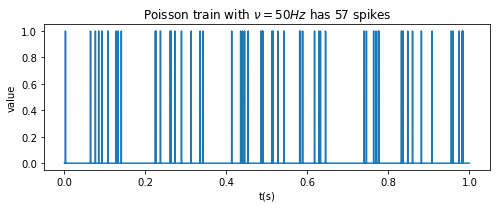

In [2]:
dt = 0.0001 # dt = 0.1msec
t = np.arange(0.0, 1.0, dt)
rate = 50

spikes = np.random.rand(len(t)) < rate*dt #Determine list of times of spikes
spikes = spikes.astype(int)

fig, ax = plt.subplots(figsize=(7,3))
ax.plot(t, spikes)
ax.set(title=f"Poisson train with $ν = 50Hz$ has {np.sum(spikes)} spikes",
       xlabel="t(s)",
       ylabel="value")
fig.tight_layout()
fig.show()

Number of spikes histogram

In [3]:
dt = 0.0001 # dt = 0.1msec
t = np.arange(0.0, 1.0, dt)
rate = 50

n_runs = 10000
results = np.zeros(n_runs)
for i in range(n_runs):
    spikes = np.random.rand(len(t)) < rate*dt #Determine list of times of spikes
    spikes = spikes.astype(int)
    results[i] = np.sum(spikes)

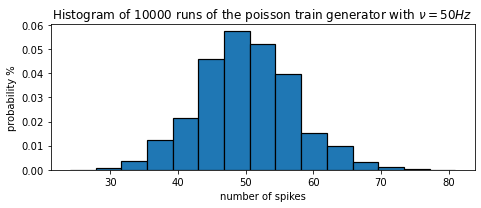

In [4]:
fig, ax = plt.subplots(figsize=(7,3))
ax.hist(results,15,density=True,edgecolor='black', linewidth=1.2)
ax.set(title=f"Histogram of {n_runs} runs of the poisson train generator with $ν = 50Hz$",
       xlabel="number of spikes",
       ylabel="probability %")
fig.tight_layout()
fig.show()

Time between spikes histogram

In [5]:
dt = 0.0001 # dt = 0.1 msec
t = np.arange(0.0, 1.0, dt)
rate = 50

n_runs = 100
intervals = []
for i in range(n_runs):
    spikes = np.random.rand(len(t)) < rate*dt #Determine list of times of spikes
    index = np.where(spikes)[0]
    intervals.append(index[1:]-index[:-1])
    
intervals = np.concatenate(intervals).ravel()

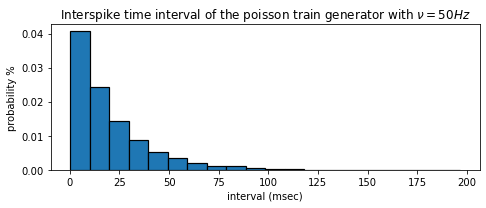

In [6]:
fig, ax = plt.subplots(figsize=(7,3))
ax.hist(intervals*0.1,20,density=True,edgecolor='black', linewidth=1.2)
ax.set(title=f"Interspike time interval of the poisson train generator with $ν = 50Hz$",
       xlabel="interval (msec)",
       ylabel="probability %")
fig.tight_layout()
fig.show()

In [7]:
def spike_train(d, rate, dt):
    """ Generates Poisson delta train
    Params:
    d (int): duration in milliseconds of the train
    rate (int): how many firings per second (Hz)
    dt (float): time differential used in the simulation
    Returns:
    result (np.array) with the indexes of the spikes
    """
    # As the standard dt is 1ms and this is not enough for this method to
    # give accurate results I add a reduction factor to spike generation
    n = int(d/dt)
    spikes = np.random.rand(n) < rate/1000*dt # Here we divide by 1000 bc milliseconds
    index = np.where(spikes)[0]
    return index*dt

**2-Study of the post-synaptic potentials induced by the Poisson train.**

From the spike train obtained in (1), generate a synaptic input $g_{syn}(t) = \hat{g}\sum_j\alpha(t-t_j)H(t-t_j)$ where $\alpha (t) = 1/\tau_{s}^{2}t\text{exp}(-t/\tau_{s})$ and $H$ is the Heaviside function. Inject it into the system (you can try to inject the first only):

$$CV = I - g_L(V-E_L)-g_{Na}m_{\infty}(V)(V-E_{Na})-g_Kn(V-E_K)+g_{syn}(t)(V-E_{syn})$$
$$\tau_nn = n_{\infty}(V)-n$$

with
$$m_{\infty}(V) = 1./(1.+exp(-(V-V_{max,m})/k_m))$$
and
$$n_{\infty}(V) = 1./(1.+exp(-(V-V_{max,n})/k_n))$$

In [8]:
# global model variables
ena, ek, el, esyn = 60, -90, -80, -90
gna, gk, gl = 20, 10, 8 
C, I = 1, 0
vmaxm, vmaxn = -20, -25
km, kn = 15, 5
taun, taus = 1, 5 

Synaptic excitation function

In [9]:
def alfa(t):
    return 1/taus**2*t*np.e**(-t/taus)
def step(t):
    return 1 if t > 0 else 0
def gsyn(t, train):
    result = 0
    for it in train:
        result += alfa(t-it)*step(t-it)
    return result

Synaptic excitation run with simple input

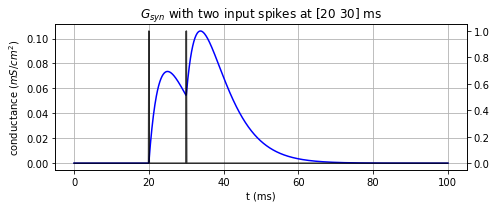

In [10]:
results = []
spikes = np.array([20,30])
time_span = np.linspace(0,100,1000)
for t in np.linspace(0,100,1000):
    results.append(gsyn(t, spikes))

fig, ax = plt.subplots(figsize=(7,3))
ax.plot(time_span, results, c='b')

ax2 = ax.twinx()
spike_p = np.zeros(time_span.shape[0])
spike_p[spikes*10] += 1
ax2.plot(time_span, spike_p,c='k',alpha=0.8,)

ax.set(title="$G_{syn}$ "+f"with two input spikes at {spikes} ms",
       xlabel="t (ms)",
       ylabel="conductance ($mS/cm^2$)")
ax.grid()

fig.tight_layout()
fig.show()

Synaptic excitation run with complex input

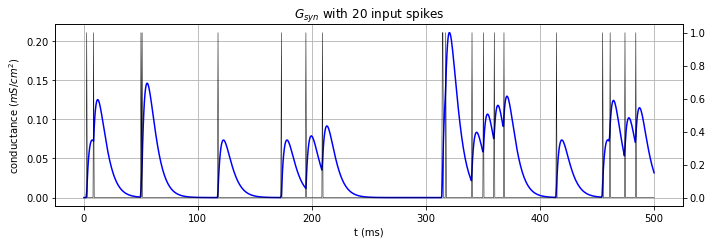

In [11]:
dt=0.1 # 0.1ms
d = 500
time_span = np.linspace(0,500,1000)
spikes = spike_train(d, 50, dt)
results = []
for t in time_span:
    results.append(gsyn(t, spikes))

fig, ax = plt.subplots(figsize=(10,3.5))
ax.plot(time_span, results,lw=1.5, c='b')

ax2 = ax.twinx()
spike_p = np.zeros(1000)
spike_p[np.rint(spikes*2).astype(int)] += 1   # Multiply by quotient of d/n_samples
ax2.plot(time_span, spike_p, c='k',alpha=1, lw=0.5)

ax.set(title="$G_{syn}$ "+f"with {spikes.shape[0]} input spikes",
       xlabel="t (ms)",
       ylabel="conductance ($mS/cm^2$)")
ax.grid()

fig.tight_layout()
fig.show()

Neuron equations

In [85]:
def minf(V):
    return 1/(1+np.e**(-(V-vmaxm)/km))
def ninf(V):
    return 1/(1+np.e**(-(V-vmaxn)/kn))
def neuron_wo_syn(X, t, I=0): 
    
    V = X[0]
    n = X[1]
    
    dVdt = (I - gl*(V-el) - gna*minf(V)*(V-ena) - gk*n*(V-ek))/C
    dndt = (ninf(V) - n)/taun
    
    return [dVdt, dndt]

def neuron(X, t, I=0, excitation=[2]): 
    
    V = X[0]
    n = X[1]
    
    dVdt = (I - gl*(V-el) - gna*minf(V)*(V-ena) - gk*n*(V-ek) + 7*excitation[int(t)]*(V-esyn))/C
    dndt = (ninf(V) - n)/taun
    
    return [dVdt, dndt]

Temporal run without synapsis excitation

In [13]:
from scipy.integrate import odeint
from functools import partial

In [14]:
def get_displacement(param, dmax=50,time_span=np.linspace(0,200, 1000), number=3):
    # We start from the resting point...
    ic = odeint(partial(neuron_wo_syn, **param),
                                                      y0=[0,0],
                                                      t= np.linspace(0,999, 1000))[-1]
    # and do some displacement of the potential. 
    traj = [] 
    for displacement in np.linspace(0,dmax, number):
        traj.append(odeint(partial(neuron_wo_syn, **param),
                                                      y0=ic+np.array([displacement,0]),
                                                      t=time_span))
    return traj

In [15]:
# Simulation params
time_span = np.linspace(0.0, 10.0, 1000)
Iapp = [{"I": 0},{"I": 30},{"I": 300}]

# Do the numerical integration.
trajectories = {} # We store the trajectories in a dictionnary, it is easier to recover them. 
for i,param in enumerate(Iapp):
    trajectories[i] = get_displacement(param, time_span=time_span, dmax=50,  number=3)

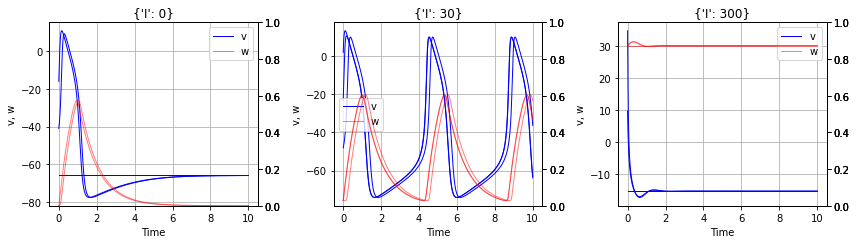

In [16]:
fig, ax = plt.subplots(1, len(Iapp), figsize=(4*len(Iapp),3.5))
for i,param in enumerate(Iapp):
        ax[i].set(xlabel='Time', ylabel='v, w',
                     title='{}'.format(param))
        for j in range(len(trajectories[i])):
            v = ax[i].plot(time_span,trajectories[i][j][:,0], color='b', lw=1)
            ax2 = ax[i].twinx()
            w = ax2.plot(time_span,trajectories[i][j][:,1], color='r', lw=1, alpha=0.5)
            ax2.set(ylim=(0,1))
        ax[i].legend([v[0],w[0]],['v','w'])
        ax[i].grid(True)
plt.tight_layout()

In [17]:
#TODO: ADD ISOCLINES, FLOW AND PHASE PLOT FOR THE THREE SCENARIOS

F-I curve no synaptical excitation

In [18]:
from collections import Counter

def count_peaks(temporal_series, thr):
    # List of values
    values = temporal_series>-thr
    values = values.astype('int')
    # Computes the crossing 1: ascendent -1: descendent
    difference = values[1:]-values[:-1]
    # Count the number of 1 (ascendent crossings)
    peaks = Counter(difference)[1]
    
    return peaks

In [20]:
dt=0.1
ms = 1000
t = np.arange(0.0, ms, dt)
s0=[-66, 0]

Iapps = np.arange(-10,180,1)

freq_store = np.zeros(Iapps.shape[0])

for ix,I in enumerate(Iapps):
    run = odeint(neuron_wo_syn, s0, t, args=(I,))
    peaks = count_peaks(run[:,0], 0)
    freq = peaks/ms*1000
    freq_store[ix] = freq

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))

ax.plot(Iapps, freq_store, lw=2.0, c='b')

ax.set(title="F-I plot of neuron model",
       xlabel="$I (mA)$",
       ylabel="Frequency (Hz)",
       xlim=(-5,165))
ax.grid()

fig.tight_layout()
fig.show()

Temporal run with synaptical excitation

In [22]:
def compute_syn_current(spikes, time_span):
    # Create synaptic excitation
    results = np.zeros(time_span.shape[0])
    for it, t in enumerate(time_span):
        results[it] = (gsyn(t, spikes))
    
    return results, results.mean()

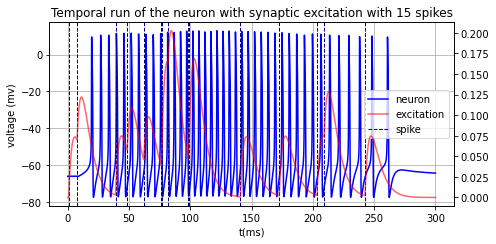

In [94]:
time_span = np.linspace(0.0, 300.0, 3000)
spikes = spike_train(300, 50, 0.1)

syn, mean = compute_syn_current(spikes, time_span)

run = odeint(partial(neuron, **{"excitation":syn}), y0=[-66,0], t=time_span)

fig, ax = plt.subplots(1, figsize=(7,3.5))

# Plot neuron response
l1, = ax.plot(time_span, run[:,0], c='b', label='neuron')

# Plot spike lines
for t in spikes:
    l3 = ax.axvline(x=t, color='darkblue', linestyle='dashed', linewidth=1, label='spike')

# Create synaptic excitation
results = np.zeros(time_span.shape[0])
for it, t in enumerate(time_span):
    results[it] = (gsyn(t, spikes))

# And plot it in secondary axes
ax2 = ax.twinx()
l2, = ax2.plot(time_span,results, c='r', alpha=0.6, label='excitation')

ax.set(title=f"Temporal run of the neuron with synaptic excitation with {spikes.shape[0]} spikes",
   xlabel="t(ms)",
   ylabel="voltage (mv)",
   )
ax.grid()

lines = [l1,l2,l3]
ax.legend(lines, [l.get_label() for l in lines])


fig.tight_layout()
fig.show()

F-I plot with average synaptic input current

In [28]:
time_span = np.linspace(0.0, 1000.0, 10000+1)

rates = np.linspace(0,1000,11)

currents = np.zeros(rates.shape[0])
freqs = np.zeros(rates.shape[0])

for i,r in enumerate(rates):
    print(f"Now computing rate: {r} {i}/{rates.shape[0]}")
    spikes = spike_train(1000, r, 0.1)
    
    syn, mean = compute_syn_current(spikes, time_span)
    
    currents[i] = mean
    
    run = odeint(partial(neuron, **{"excitation":syn}), y0=[-66,0], t=time_span)

    
    peaks = count_peaks(run[:,0], 0)
    freqs[i] = peaks/ms*1000

Now rate: 0.0
Now rate: 100.0
Now rate: 200.0
Now rate: 300.0
Now rate: 400.0
Now rate: 500.0
Now rate: 600.0
Now rate: 700.0
Now rate: 800.0
Now rate: 900.0
Now rate: 1000.0


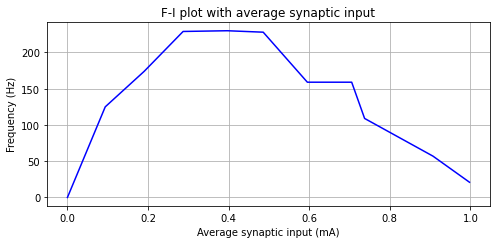

In [95]:
fig, ax = plt.subplots(1, figsize=(7,3.5))

ax.plot(currents, freqs, c='b') 

ax.set(title=f"F-I plot with average synaptic input",
   xlabel="Average synaptic input (mA)",
   ylabel="Frequency (Hz)",
   )
ax.grid()


fig.tight_layout()
fig.show()